📋 Configuration
Input path: C:\Users\Luca\OneDrive - Università Commerciale Luigi Bocconi\Desktop\fishtest_2018
Max games: 10000
Min moves: 10

✅ Directory found!
   • PGN files: 37
   • Total size: 766.3 MB

🔧 Loading feature extraction functions...
✅ Functions loaded

🔄 PROCESSING GAMES (BOTH COLORS)


Processing: 100%|██████████| 10000/10000 [23:54<00:00,  6.97it/s]



✅ 9999 games processed
   (1 skipped)

🧹 Preparing data...
✅ Features: 18
   White observations: 597929
   Black observations: 602243

🎯 COMPUTING 2 UNIFIED PCAs (White & Black)

📊 White Unified PCA...

📊 Black Unified PCA...

📈 VARIANCE EXPLAINED
White (unified): PCA1=14.10%, PCA2=11.63%, Total=25.73%
Black (unified): PCA1=13.02%, PCA2=12.61%, Total=25.63%

📊 Computing average trajectories...
📈 Creating visualizations...



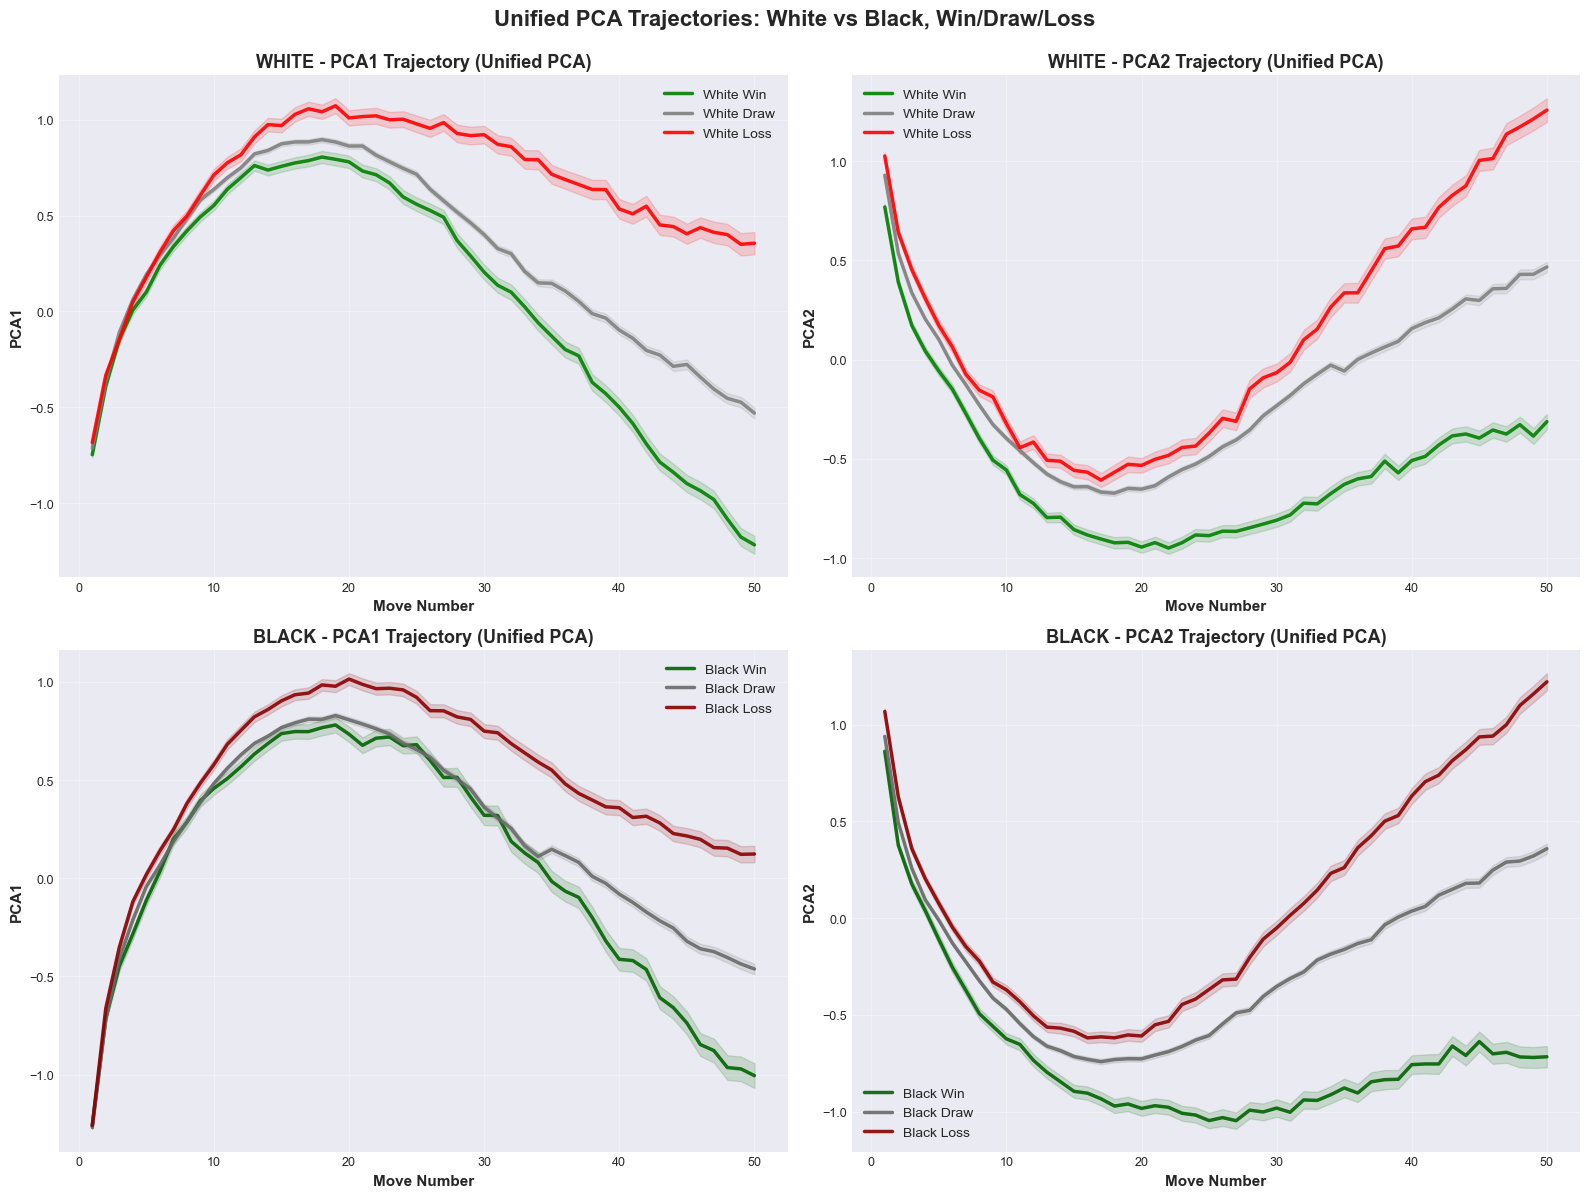


🎯 LOADINGS COMPARISON (Unified PCAs)

WHITE (Unified PCA)
──────────────────────────────────────────────────
PCA1 (Top 5 by absolute value):
  ➖ cnt_pawn                 : -0.457
  ➖ pawns_passed_diff        : -0.432
  ➕ captures_avail           : +0.414
  ➕ mobility                 : +0.357
  ➕ attack_overlap           : +0.328

PCA2 (Top 5 by absolute value):
  ➖ mobility                 : -0.462
  ➖ attack_overlap           : -0.380
  ➖ captures_avail           : -0.349
  ➖ cnt_pawn                 : -0.337
  ➖ pawns_passed_diff        : -0.324

BLACK (Unified PCA)
──────────────────────────────────────────────────
PCA1 (Top 5 by absolute value):
  ➕ captures_avail           : +0.449
  ➖ cnt_pawn                 : -0.430
  ➖ pawns_passed_diff        : -0.413
  ➕ mobility                 : +0.396
  ➕ attack_overlap           : +0.363

PCA2 (Top 5 by absolute value):
  ➖ mobility                 : -0.424
  ➖ cnt_pawn                 : -0.407
  ➖ pawns_passed_diff        : -0.383
  ➖ 

In [5]:
# Chess Game Analysis with UNIFIED PCA per Color
# Analisi con 2 PCA: una per Bianco, una per Nero (poi separazione per risultato)

import io, gzip
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from tqdm import tqdm
import chess
import chess.pgn

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 5)

# ===== CONFIGURATION =====
print("📋 Configuration")
print("="*60)

INPUT_PATH = r"C:\Users\Luca\OneDrive - Università Commerciale Luigi Bocconi\Desktop\fishtest_2018"
MAX_GAMES = 10000
MIN_MOVES = 10

print(f"Input path: {INPUT_PATH}")
print(f"Max games: {MAX_GAMES if MAX_GAMES else 'ALL'}")
print(f"Min moves: {MIN_MOVES}\n")

# ===== CONSTANTS =====
PIECE_VALUES = {
    chess.PAWN: 100, chess.KNIGHT: 320, chess.BISHOP: 330,
    chess.ROOK: 500, chess.QUEEN: 900, chess.KING: 20000
}

CENTER_SQ = [chess.D4, chess.E4, chess.D5, chess.E5]
EXT_CENTER = [chess.C3, chess.C4, chess.C5, chess.C6, chess.D3, chess.E3,
              chess.D6, chess.E6, chess.F3, chess.F4, chess.F5, chess.F6]

# ===== UTILITY FUNCTIONS =====
def _human_size(num_bytes: int) -> str:
    for unit in ["B", "KB", "MB", "GB", "TB"]:
        if num_bytes < 1024.0:
            return f"{num_bytes:3.1f} {unit}"
        num_bytes /= 1024.0
    return f"{num_bytes:.1f} PB"

def _is_pgn_file(path: Path) -> bool:
    if not path.is_file():
        return False
    name = path.name.lower()
    return name.endswith(".pgn") or name.endswith(".pgn.gz")

def _open_pgn(path: Path):
    if path.suffix.lower() == ".gz" or path.name.lower().endswith(".pgn.gz"):
        return gzip.open(path, "rt", encoding="utf-8", errors="ignore")
    return open(path, "r", encoding="utf-8", errors="ignore")

def iter_games_from_path(path: Path, limit: int = None):
    count = 0
    if path.is_file():
        if not _is_pgn_file(path):
            raise ValueError(f"File is not a PGN: {path}")
        with _open_pgn(path) as f:
            while True:
                if limit is not None and count >= limit:
                    return
                try:
                    game = chess.pgn.read_game(f)
                    if game is None:
                        break
                    yield game
                    count += 1
                except Exception as e:
                    print(f"⚠️ Error reading game {count+1}: {e}")
                    continue
    else:
        files = sorted(list(path.rglob("*.pgn")) + list(path.rglob("*.pgn.gz")))
        for fp in files:
            with _open_pgn(fp) as f:
                while True:
                    if limit is not None and count >= limit:
                        return
                    try:
                        game = chess.pgn.read_game(f)
                        if game is None:
                            break
                        yield game
                        count += 1
                    except Exception as e:
                        print(f"⚠️ Error in {fp.name}: {e}")
                        continue

# Validate path
p = Path(INPUT_PATH)
if not p.exists():
    raise FileNotFoundError(f"❌ Path not found: {INPUT_PATH}")

if p.is_file():
    if not _is_pgn_file(p):
        raise ValueError(f"❌ Not a PGN file: {p}")
    size = p.stat().st_size
    print(f"✅ File found! Size: {_human_size(size)}\n")
else:
    pgn_files = list(p.rglob("*.pgn")) + list(p.rglob("*.pgn.gz"))
    if not pgn_files:
        raise FileNotFoundError(f"❌ No PGN files in {INPUT_PATH}")
    total_bytes = sum(fp.stat().st_size for fp in pgn_files)
    print(f"✅ Directory found!")
    print(f"   • PGN files: {len(pgn_files)}")
    print(f"   • Total size: {_human_size(total_bytes)}\n")

# ===== FEATURE EXTRACTION =====
print("🔧 Loading feature extraction functions...")

def material_eval(b, perspective_color):
    """Material balance from perspective_color's viewpoint"""
    mat = sum(PIECE_VALUES[pt] * (len(b.pieces(pt, chess.WHITE)) -
               len(b.pieces(pt, chess.BLACK))) for pt in PIECE_VALUES)
    return mat if perspective_color == chess.WHITE else -mat

def piece_counts(b, perspective_color):
    """Piece count difference from perspective"""
    diff = 1 if perspective_color == chess.WHITE else -1
    return {f"cnt_{chess.piece_name(pt)}": diff * (len(b.pieces(pt, chess.WHITE)) -
            len(b.pieces(pt, chess.BLACK)))
            for pt in [chess.PAWN, chess.KNIGHT, chess.BISHOP, chess.ROOK, chess.QUEEN]}

def mobility_stats(b, color):
    """Mobility, captures, checks for given color"""
    tmp = b.copy(stack=False)
    tmp.turn = color
    moves = list(tmp.legal_moves)
    return (len(moves),
            sum(1 for m in moves if tmp.is_capture(m)),
            sum(1 for m in moves if tmp.gives_check(m)))

def attack_overlap(b):
    """Squares attacked by both colors"""
    return sum(1 for sq in chess.SQUARES 
               if b.attackers(chess.WHITE, sq) and b.attackers(chess.BLACK, sq))

def hanging_pieces(b, perspective_color):
    """Undefended pieces (positive = advantage for perspective_color)"""
    def count(color):
        return sum(1 for sq in chess.SquareSet(b.occupied_co[color])
                   if b.attackers(not color, sq) and not b.attackers(color, sq))
    diff = count(not perspective_color) - count(perspective_color)
    return diff

def center_control(b, perspective_color):
    """Center control from perspective"""
    def ctrl(c, sqs): 
        return sum(1 for sq in sqs if b.attackers(c, sq))
    
    opp = not perspective_color
    core = ctrl(perspective_color, CENTER_SQ) - ctrl(opp, CENTER_SQ)
    ext = ctrl(perspective_color, EXT_CENTER) - ctrl(opp, EXT_CENTER)
    return core, ext

def king_safety(b, perspective_color):
    """King safety difference (positive = advantage)"""
    def safety(c):
        ksq = b.king(c)
        if ksq is None: 
            return 0
        kf, kr = chess.square_file(ksq), chess.square_rank(ksq)
        ring = [chess.square(kf+df, kr+dr) for df in [-1,0,1] for dr in [-1,0,1]
                if (df or dr) and 0<=kf+df<=7 and 0<=kr+dr<=7]
        attacks = sum(1 for sq in ring if b.attackers(not c, sq))
        shield = sum(1 for fo in [-1,0,1]
                     if 0<=kf+fo<=7 and 0<=kr+(1 if c==chess.WHITE else -1)<=7
                     and b.piece_type_at(chess.square(kf+fo, kr+(1 if c==chess.WHITE else -1)))==chess.PAWN
                     and b.color_at(chess.square(kf+fo, kr+(1 if c==chess.WHITE else -1)))==c)
        return shield - attacks
    
    return safety(perspective_color) - safety(not perspective_color)

def pawn_structure(b, perspective_color):
    """Pawn structure from perspective"""
    def feat(c):
        pawns = b.pieces(chess.PAWN, c)
        files = [chess.square_file(sq) for sq in pawns]
        doubled = sum(max(0, files.count(f)-1) for f in range(8))
        isolated = sum(1 for f in range(8) if files.count(f)>0 and
                       files.count(f-1)==0 and files.count(f+1)==0)
        passed = 0
        for sq in pawns:
            sq_file = chess.square_file(sq)
            ahead_range = range(sq+8, 64, 8) if c == chess.WHITE else range(sq-8, -1, -8)
            blocked = False
            for a in ahead_range:
                a_file = chess.square_file(a)
                if a_file in [sq_file-1, sq_file, sq_file+1]:
                    if b.piece_type_at(a) == chess.PAWN and b.color_at(a) != c:
                        blocked = True
                        break
            if not blocked:
                passed += 1
        return doubled, isolated, passed

    opp = not perspective_color
    dP, iP, pP = feat(perspective_color)
    dO, iO, pO = feat(opp)
    return (dP-dO, iP-iO, pP-pO)

print("✅ Functions loaded\n")

# ===== FEATURE EXTRACTION PER GAME =====
def extract_features_both_colors(game):
    """Extract features for BOTH White and Black moves"""
    board = game.board()
    white_rows = []
    black_rows = []
    ply = 0

    try:
        for move in game.mainline_moves():
            board.push(move)
            ply += 1

            # Determine who just moved
            player_color = chess.BLACK if board.turn == chess.BLACK else chess.WHITE
            
            # Extract features from player's perspective
            mob, cap, chk = mobility_stats(board, player_color)
            mat = material_eval(board, player_color)
            counts = piece_counts(board, player_color)
            core, ext = center_control(board, player_color)
            pawn_d, pawn_i, pawn_p = pawn_structure(board, player_color)

            row = {
                'ply': ply,
                'material': mat,
                'mobility': mob,
                'captures_avail': cap,
                'checks_avail': chk,
                'attack_overlap': attack_overlap(board),
                'hanging_diff': hanging_pieces(board, player_color),
                'center_core': core,
                'center_ext': ext,
                'king_safety_diff': king_safety(board, player_color),
                'pawns_doubled_diff': pawn_d,
                'pawns_isolated_diff': pawn_i,
                'pawns_passed_diff': pawn_p,
                **counts
            }

            if player_color == chess.WHITE:
                row['move_num'] = len(white_rows) + 1
                white_rows.append(row)
            else:
                row['move_num'] = len(black_rows) + 1
                black_rows.append(row)

    except Exception as e:
        return None, None

    if len(white_rows) < MIN_MOVES or len(black_rows) < MIN_MOVES:
        return None, None

    # Get result
    result = game.headers.get('Result', '*')
    if result not in ['1-0', '0-1', '1/2-1/2']:
        return None, None

    # Create DataFrames
    df_white = pd.DataFrame(white_rows)
    df_black = pd.DataFrame(black_rows)

    # Add result from each perspective
    if result == '1-0':
        df_white['result'] = 'W'
        df_black['result'] = 'L'
    elif result == '0-1':
        df_white['result'] = 'L'
        df_black['result'] = 'W'
    else:
        df_white['result'] = 'D'
        df_black['result'] = 'D'

    # Add delta mobility
    df_white['delta_mobility'] = df_white['mobility'].diff().fillna(0)
    df_black['delta_mobility'] = df_black['mobility'].diff().fillna(0)

    return df_white, df_black

# ===== PROCESS GAMES =====
print("="*60)
print("🔄 PROCESSING GAMES (BOTH COLORS)")
print("="*60)

white_games = []
black_games = []
parsed_count = 0
skipped_count = 0

game_generator = iter_games_from_path(p, limit=MAX_GAMES)

for game in tqdm(game_generator, desc="Processing", total=MAX_GAMES):
    parsed_count += 1
    
    df_w, df_b = extract_features_both_colors(game)
    if df_w is not None and df_b is not None:
        white_games.append(df_w)
        black_games.append(df_b)
    else:
        skipped_count += 1

if not white_games:
    raise ValueError("❌ No valid games found!")

print(f"\n✅ {len(white_games)} games processed")
print(f"   ({skipped_count} skipped)\n")

# ===== CONCATENATE DATA =====
print("🧹 Preparing data...")

white_data = pd.concat(white_games, keys=range(len(white_games)), names=['game_id', 'idx'])
white_data = white_data.reset_index(level=0)
white_data['color'] = 'white'

black_data = pd.concat(black_games, keys=range(len(black_games)), names=['game_id', 'idx'])
black_data = black_data.reset_index(level=0)
black_data['color'] = 'black'

# Define features
FEATURES = [c for c in white_data.select_dtypes(include=[np.number]).columns
            if c not in ['ply', 'move_num', 'game_id']]

# Clean data
for df in [white_data, black_data]:
    df[FEATURES] = df[FEATURES].replace([np.inf, -np.inf], np.nan).fillna(0)

print(f"✅ Features: {len(FEATURES)}")
print(f"   White observations: {len(white_data)}")
print(f"   Black observations: {len(black_data)}\n")

# ===== 2 UNIFIED PCAs (One per Color) =====
print("="*60)
print("🎯 COMPUTING 2 UNIFIED PCAs (White & Black)")
print("="*60)

def compute_unified_pca(data, color_name):
    """
    Compute ONE PCA using ALL observations for a color,
    then project and separate by result afterwards
    """
    print(f"\n📊 {color_name} Unified PCA...")
    
    # Fit PCA on ALL data for this color
    X = data[FEATURES].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    pca = PCA(n_components=2, random_state=42)
    components = pca.fit_transform(X_scaled)
    
    # Add PCA coordinates to the full dataset
    data = data.copy()
    data['PCA1'] = components[:, 0]
    data['PCA2'] = components[:, 1]
    
    # Compute loadings
    loadings = pd.DataFrame(
        pca.components_.T,
        index=FEATURES,
        columns=['PCA1', 'PCA2']
    )
    
    # NOW split by result (after projection)
    subset_win = data[data['result'] == 'W'].copy()
    subset_draw = data[data['result'] == 'D'].copy()
    subset_loss = data[data['result'] == 'L'].copy()
    
    return {
        'pca': pca,
        'loadings': loadings,
        'scaler': scaler,
        'win': subset_win if len(subset_win) >= 50 else None,
        'draw': subset_draw if len(subset_draw) >= 50 else None,
        'loss': subset_loss if len(subset_loss) >= 50 else None
    }

# Compute 2 unified PCAs
white_unified = compute_unified_pca(white_data, "White")
black_unified = compute_unified_pca(black_data, "Black")

# Extract subsets for convenience
white_win = white_unified['win']
white_draw = white_unified['draw']
white_loss = white_unified['loss']
pca_white = white_unified['pca']
load_white = white_unified['loadings']

black_win = black_unified['win']
black_draw = black_unified['draw']
black_loss = black_unified['loss']
pca_black = black_unified['pca']
load_black = black_unified['loadings']

# Print variance explained
print("\n" + "="*60)
print("📈 VARIANCE EXPLAINED")
print("="*60)
var1_w, var2_w = pca_white.explained_variance_ratio_
var1_b, var2_b = pca_black.explained_variance_ratio_
print(f"White (unified): PCA1={var1_w:.2%}, PCA2={var2_w:.2%}, Total={var1_w+var2_w:.2%}")
print(f"Black (unified): PCA1={var1_b:.2%}, PCA2={var2_b:.2%}, Total={var1_b+var2_b:.2%}")

# ===== TRAJECTORY COMPUTATION =====
print("\n📊 Computing average trajectories...")

max_moves = 50

def compute_trajectory(subset):
    """Compute average trajectory for a subset"""
    if subset is None or len(subset) == 0:
        return None, None
    
    subset = subset[subset['move_num'] <= max_moves].copy()
    avg = subset.groupby('move_num')[['PCA1', 'PCA2']].mean()
    std = subset.groupby('move_num')[['PCA1', 'PCA2']].std()
    n = subset.groupby('move_num').size().clip(lower=1)
    se = std.div(np.sqrt(n), axis=0)
    
    return avg, se

traj_ww, se_ww = compute_trajectory(white_win)
traj_wd, se_wd = compute_trajectory(white_draw)
traj_wl, se_wl = compute_trajectory(white_loss)
traj_bw, se_bw = compute_trajectory(black_win)
traj_bd, se_bd = compute_trajectory(black_draw)
traj_bl, se_bl = compute_trajectory(black_loss)

# ===== MAIN VISUALIZATION =====
print("📈 Creating visualizations...\n")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Unified PCA Trajectories: White vs Black, Win/Draw/Loss', 
             fontsize=16, fontweight='bold', y=0.995)

# Plot 1: White PCA1
ax = axes[0, 0]
if traj_ww is not None:
    x = traj_ww.index
    ax.plot(x, traj_ww['PCA1'], color='green', linewidth=2.5, label='White Win', alpha=0.9)
    ax.fill_between(x, traj_ww['PCA1']-se_ww['PCA1'], traj_ww['PCA1']+se_ww['PCA1'],
                     color='green', alpha=0.15)
if traj_wd is not None:
    x = traj_wd.index
    ax.plot(x, traj_wd['PCA1'], color='gray', linewidth=2.5, label='White Draw', alpha=0.9)
    ax.fill_between(x, traj_wd['PCA1']-se_wd['PCA1'], traj_wd['PCA1']+se_wd['PCA1'],
                     color='gray', alpha=0.15)
if traj_wl is not None:
    x = traj_wl.index
    ax.plot(x, traj_wl['PCA1'], color='red', linewidth=2.5, label='White Loss', alpha=0.9)
    ax.fill_between(x, traj_wl['PCA1']-se_wl['PCA1'], traj_wl['PCA1']+se_wl['PCA1'],
                     color='red', alpha=0.15)
ax.set_xlabel('Move Number', fontsize=11, fontweight='bold')
ax.set_ylabel('PCA1', fontsize=11, fontweight='bold')
ax.set_title('WHITE - PCA1 Trajectory (Unified PCA)', fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: White PCA2
ax = axes[0, 1]
if traj_ww is not None:
    x = traj_ww.index
    ax.plot(x, traj_ww['PCA2'], color='green', linewidth=2.5, label='White Win', alpha=0.9)
    ax.fill_between(x, traj_ww['PCA2']-se_ww['PCA2'], traj_ww['PCA2']+se_ww['PCA2'],
                     color='green', alpha=0.15)
if traj_wd is not None:
    x = traj_wd.index
    ax.plot(x, traj_wd['PCA2'], color='gray', linewidth=2.5, label='White Draw', alpha=0.9)
    ax.fill_between(x, traj_wd['PCA2']-se_wd['PCA2'], traj_wd['PCA2']+se_wd['PCA2'],
                     color='gray', alpha=0.15)
if traj_wl is not None:
    x = traj_wl.index
    ax.plot(x, traj_wl['PCA2'], color='red', linewidth=2.5, label='White Loss', alpha=0.9)
    ax.fill_between(x, traj_wl['PCA2']-se_wl['PCA2'], traj_wl['PCA2']+se_wl['PCA2'],
                     color='red', alpha=0.15)
ax.set_xlabel('Move Number', fontsize=11, fontweight='bold')
ax.set_ylabel('PCA2', fontsize=11, fontweight='bold')
ax.set_title('WHITE - PCA2 Trajectory (Unified PCA)', fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 3: Black PCA1
ax = axes[1, 0]
if traj_bw is not None:
    x = traj_bw.index
    ax.plot(x, traj_bw['PCA1'], color='darkgreen', linewidth=2.5, label='Black Win', alpha=0.9)
    ax.fill_between(x, traj_bw['PCA1']-se_bw['PCA1'], traj_bw['PCA1']+se_bw['PCA1'],
                     color='darkgreen', alpha=0.15)
if traj_bd is not None:
    x = traj_bd.index
    ax.plot(x, traj_bd['PCA1'], color='dimgray', linewidth=2.5, label='Black Draw', alpha=0.9)
    ax.fill_between(x, traj_bd['PCA1']-se_bd['PCA1'], traj_bd['PCA1']+se_bd['PCA1'],
                     color='dimgray', alpha=0.15)
if traj_bl is not None:
    x = traj_bl.index
    ax.plot(x, traj_bl['PCA1'], color='darkred', linewidth=2.5, label='Black Loss', alpha=0.9)
    ax.fill_between(x, traj_bl['PCA1']-se_bl['PCA1'], traj_bl['PCA1']+se_bl['PCA1'],
                     color='darkred', alpha=0.15)
ax.set_xlabel('Move Number', fontsize=11, fontweight='bold')
ax.set_ylabel('PCA1', fontsize=11, fontweight='bold')
ax.set_title('BLACK - PCA1 Trajectory (Unified PCA)', fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 4: Black PCA2
ax = axes[1, 1]
if traj_bw is not None:
    x = traj_bw.index
    ax.plot(x, traj_bw['PCA2'], color='darkgreen', linewidth=2.5, label='Black Win', alpha=0.9)
    ax.fill_between(x, traj_bw['PCA2']-se_bw['PCA2'], traj_bw['PCA2']+se_bw['PCA2'],
                     color='darkgreen', alpha=0.15)
if traj_bd is not None:
    x = traj_bd.index
    ax.plot(x, traj_bd['PCA2'], color='dimgray', linewidth=2.5, label='Black Draw', alpha=0.9)
    ax.fill_between(x, traj_bd['PCA2']-se_bd['PCA2'], traj_bd['PCA2']+se_bd['PCA2'],
                     color='dimgray', alpha=0.15)
if traj_bl is not None:
    x = traj_bl.index
    ax.plot(x, traj_bl['PCA2'], color='darkred', linewidth=2.5, label='Black Loss', alpha=0.9)
    ax.fill_between(x, traj_bl['PCA2']-se_bl['PCA2'], traj_bl['PCA2']+se_bl['PCA2'],
                     color='darkred', alpha=0.15)
ax.set_xlabel('Move Number', fontsize=11, fontweight='bold')
ax.set_ylabel('PCA2', fontsize=11, fontweight='bold')
ax.set_title('BLACK - PCA2 Trajectory (Unified PCA)', fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('chess_unified_pca.png', dpi=200, bbox_inches='tight')
plt.show()

# ===== LOADING COMPARISON =====
print("\n" + "="*60)
print("🎯 LOADINGS COMPARISON (Unified PCAs)")
print("="*60)

def print_loadings(loadings, title):
    if loadings is None:
        print(f"\n{title}: NO DATA")
        return
    print(f"\n{title}")
    print("─" * 50)
    print("PCA1 (Top 5 by absolute value):")
    top = loadings.sort_values('PCA1', key=abs, ascending=False).head(5)
    for feat, val in top['PCA1'].items():
        print(f"  {'➕' if val>0 else '➖'} {feat:25s}: {val:+.3f}")
    print("\nPCA2 (Top 5 by absolute value):")
    top = loadings.sort_values('PCA2', key=abs, ascending=False).head(5)
    for feat, val in top['PCA2'].items():
        print(f"  {'➕' if val>0 else '➖'} {feat:25s}: {val:+.3f}")

print_loadings(load_white, "WHITE (Unified PCA)")
print_loadings(load_black, "BLACK (Unified PCA)")

# ===== SUMMARY STATISTICS =====
print("\n" + "="*60)
print("📊 FINAL STATISTICS")
print("="*60)
print(f"Total games: {len(white_games)}")
print(f"\nWhite perspective:")
print(f"  Wins:   {len(white_win) if white_win is not None else 0} observations")
print(f"  Draws:  {len(white_draw) if white_draw is not None else 0} observations")
print(f"  Losses: {len(white_loss) if white_loss is not None else 0} observations")
print(f"\nBlack perspective:")
print(f"  Wins:   {len(black_win) if black_win is not None else 0} observations")
print(f"  Draws:  {len(black_draw) if black_draw is not None else 0} observations")
print(f"  Losses: {len(black_loss) if black_loss is not None else 0} observations")

print("\n" + "="*60)
print("✅ ANALYSIS COMPLETE!")
print("="*60)
print("\n💾 Output: chess_unified_pca.png")

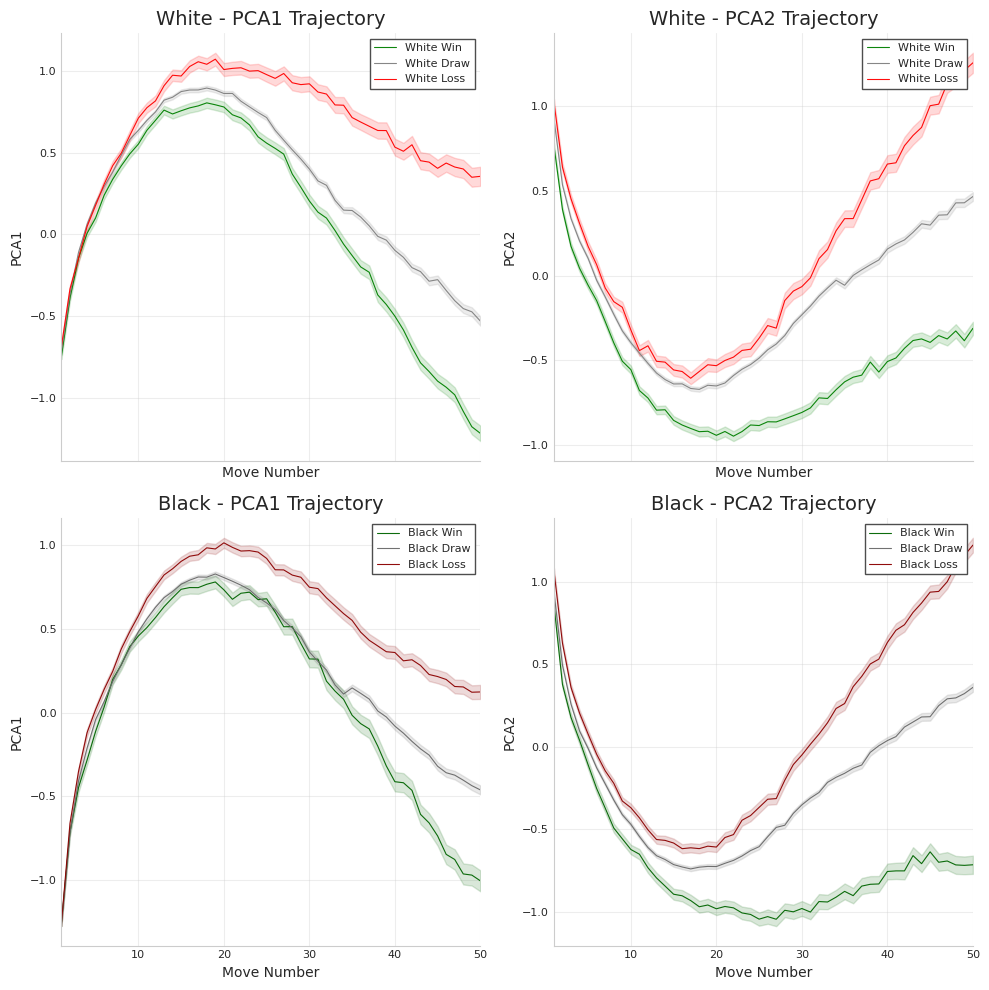

✅ Saved: trajectory_analysis_clean_square.png


In [22]:
# =========================
# CLEAN 2x2 GRID (SEABORN-LIKE, SQUARE, PAPER-READY)
# =========================
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# ---- Style: similar to your example (sans-serif + whitegrid) ----
plt.style.use("seaborn-v0_8-whitegrid")  # if this errors, use: "seaborn-whitegrid"

mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans", "Arial", "Liberation Sans"],
    "axes.titleweight": "normal",
    "axes.labelweight": "normal",
    "axes.titlesize": 14,
    "axes.labelsize": 10,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
    "axes.linewidth": 0.8,
})

def _plot_single(ax, x, y, yerr, label, color, ylabel):
    ax.plot(x, y, color=color, linewidth=0.8, label=label, alpha=0.95)
    if yerr is None:
        yerr = np.zeros_like(y)
    ax.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.15)
    ax.set_ylabel(ylabel)

def save_clean_trajectory_grid(
    # White data
    traj_ww, se_ww, traj_wd, se_wd, traj_wl, se_wl,
    # Black data
    traj_bw, se_bw, traj_bd, se_bd, traj_bl, se_bl,
    outpath: str = "trajectory_analysis_clean.png",
    max_moves: int = 50,
    figsize: tuple = (10, 10),   # <- square
    dpi: int = 300
):
    fig, axes = plt.subplots(2, 2, figsize=figsize, sharex=True)
    fig.patch.set_facecolor("white")

    # Colors (match your vibe)
    white_colors = ("green", "gray", "red")
    black_colors = ("darkgreen", "dimgray", "darkred")

    def _prep_xy(df, col):
        # robust: if index is 0-based, shift to start at 1
        x = df.index.to_numpy()
        if len(x) and np.min(x) == 0:
            x = x + 1
        y = df[col].to_numpy()
        return x, y

    def _finish_ax(ax):
        ax.set_xlim(1, max_moves)
        ax.grid(True, alpha=0.35, linestyle="-", linewidth=0.8)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    # ---------- (A) White PC1 ----------
    ax = axes[0, 0]
    if traj_ww is not None and "PCA1" in traj_ww.columns:
        x, y = _prep_xy(traj_ww, "PCA1")
        yerr = se_ww["PCA1"].to_numpy() if (se_ww is not None and "PCA1" in se_ww.columns) else None
        _plot_single(ax, x, y, yerr, "White Win",  white_colors[0], "PCA1")
    if traj_wd is not None and "PCA1" in traj_wd.columns:
        x, y = _prep_xy(traj_wd, "PCA1")
        yerr = se_wd["PCA1"].to_numpy() if (se_wd is not None and "PCA1" in se_wd.columns) else None
        _plot_single(ax, x, y, yerr, "White Draw", white_colors[1], "PCA1")
    if traj_wl is not None and "PCA1" in traj_wl.columns:
        x, y = _prep_xy(traj_wl, "PCA1")
        yerr = se_wl["PCA1"].to_numpy() if (se_wl is not None and "PCA1" in se_wl.columns) else None
        _plot_single(ax, x, y, yerr, "White Loss", white_colors[2], "PCA1")
    ax.set_title("White - PCA1 Trajectory")
    ax.legend(loc="upper right", frameon=True)
    _finish_ax(ax)

    # ---------- (B) White PC2 ----------
    ax = axes[0, 1]
    if traj_ww is not None and "PCA2" in traj_ww.columns:
        x, y = _prep_xy(traj_ww, "PCA2")
        yerr = se_ww["PCA2"].to_numpy() if (se_ww is not None and "PCA2" in se_ww.columns) else None
        _plot_single(ax, x, y, yerr, "White Win",  white_colors[0], "PCA2")
    if traj_wd is not None and "PCA2" in traj_wd.columns:
        x, y = _prep_xy(traj_wd, "PCA2")
        yerr = se_wd["PCA2"].to_numpy() if (se_wd is not None and "PCA2" in se_wd.columns) else None
        _plot_single(ax, x, y, yerr, "White Draw", white_colors[1], "PCA2")
    if traj_wl is not None and "PCA2" in traj_wl.columns:
        x, y = _prep_xy(traj_wl, "PCA2")
        yerr = se_wl["PCA2"].to_numpy() if (se_wl is not None and "PCA2" in se_wl.columns) else None
        _plot_single(ax, x, y, yerr, "White Loss", white_colors[2], "PCA2")
    ax.set_title("White - PCA2 Trajectory")
    ax.legend(loc="upper right", frameon=True)
    _finish_ax(ax)

    # ---------- (C) Black PC1 ----------
    ax = axes[1, 0]
    if traj_bw is not None and "PCA1" in traj_bw.columns:
        x, y = _prep_xy(traj_bw, "PCA1")
        yerr = se_bw["PCA1"].to_numpy() if (se_bw is not None and "PCA1" in se_bw.columns) else None
        _plot_single(ax, x, y, yerr, "Black Win",  black_colors[0], "PCA1")
    if traj_bd is not None and "PCA1" in traj_bd.columns:
        x, y = _prep_xy(traj_bd, "PCA1")
        yerr = se_bd["PCA1"].to_numpy() if (se_bd is not None and "PCA1" in se_bd.columns) else None
        _plot_single(ax, x, y, yerr, "Black Draw", black_colors[1], "PCA1")
    if traj_bl is not None and "PCA1" in traj_bl.columns:
        x, y = _prep_xy(traj_bl, "PCA1")
        yerr = se_bl["PCA1"].to_numpy() if (se_bl is not None and "PCA1" in se_bl.columns) else None
        _plot_single(ax, x, y, yerr, "Black Loss", black_colors[2], "PCA1")
    ax.set_title("Black - PCA1 Trajectory")
    ax.legend(loc="upper right", frameon=True)
    _finish_ax(ax)

    # ---------- (D) Black PC2 ----------
    ax = axes[1, 1]
    if traj_bw is not None and "PCA2" in traj_bw.columns:
        x, y = _prep_xy(traj_bw, "PCA2")
        yerr = se_bw["PCA2"].to_numpy() if (se_bw is not None and "PCA2" in se_bw.columns) else None
        _plot_single(ax, x, y, yerr, "Black Win",  black_colors[0], "PCA2")
    if traj_bd is not None and "PCA2" in traj_bd.columns:
        x, y = _prep_xy(traj_bd, "PCA2")
        yerr = se_bd["PCA2"].to_numpy() if (se_bd is not None and "PCA2" in se_bd.columns) else None
        _plot_single(ax, x, y, yerr, "Black Draw", black_colors[1], "PCA2")
    if traj_bl is not None and "PCA2" in traj_bl.columns:
        x, y = _prep_xy(traj_bl, "PCA2")
        yerr = se_bl["PCA2"].to_numpy() if (se_bl is not None and "PCA2" in se_bl.columns) else None
        _plot_single(ax, x, y, yerr, "Black Loss", black_colors[2], "PCA2")
    ax.set_title("Black - PCA2 Trajectory")
    ax.legend(loc="upper right", frameon=True)
    _finish_ax(ax)

    # Shared X labels on bottom row (pulito)
    axes[1, 0].set_xlabel("Move Number")
    axes[1, 1].set_xlabel("Move Number")
    axes[0, 0].set_xlabel("Move Number")
    axes[0, 1].set_xlabel("Move Number")

    plt.tight_layout()
    plt.savefig(outpath, dpi=dpi)
    plt.show()
    print(f"✅ Saved: {outpath}")

# --- Call ---
save_clean_trajectory_grid(
    traj_ww, se_ww, traj_wd, se_wd, traj_wl, se_wl,
    traj_bw, se_bw, traj_bd, se_bd, traj_bl, se_bl,
    outpath="trajectory_analysis_clean_square.png",
    max_moves=max_moves,
    figsize=(10, 10),
    dpi=300
)

def save_single_panel(
    traj_win, se_win,
    traj_draw, se_draw,
    traj_loss, se_loss,
    pc: str,
    title: str,
    colors: dict,
    outpath: str,
    max_moves: int = 50,
    figsize: tuple = (6, 6),
    dpi: int = 300
):
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor("white")

    def _prep_xy(df):
        x = df.index.to_numpy()
        if len(x) and x.min() == 0:
            x = x + 1
        return x

    def _plot(df, se, label, color):
        if df is None or pc not in df.columns:
            return
        x = _prep_xy(df)
        y = df[pc].to_numpy()
        yerr = se[pc].to_numpy() if (se is not None and pc in se.columns) else None

        ax.plot(x, y, linewidth=0.8, color=color, alpha=0.95, label=label)
        if yerr is not None:
            ax.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.15)

    _plot(traj_win,  se_win,  "Win",  colors["Win"])
    _plot(traj_draw,se_draw, "Draw", colors["Draw"])
    _plot(traj_loss,se_loss, "Loss", colors["Loss"])

    ax.set_title(title, fontweight="normal")
    ax.set_xlabel("Move Number")
    ax.set_ylabel(pc)
    ax.set_xlim(1, max_moves)

    ax.grid(True, alpha=0.35)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.legend(loc="upper right", frameon=True)

    plt.tight_layout()
    plt.savefig(outpath, dpi=dpi)
    plt.close(fig)

def save_all_panels(
    traj_ww, se_ww, traj_wd, se_wd, traj_wl, se_wl,
    traj_bw, se_bw, traj_bd, se_bd, traj_bl, se_bl,
    max_moves: int = 50
):
    white_colors = {"Win": "green", "Draw": "gray", "Loss": "red"}
    black_colors = {"Win": "darkgreen", "Draw": "dimgray", "Loss": "darkred"}

    save_single_panel(
        traj_ww, se_ww, traj_wd, se_wd, traj_wl, se_wl,
        pc="PCA1",
        title="WHITE - PCA1 Trajectory",
        colors=white_colors,
        outpath="white_pca1.png",
        max_moves=max_moves
    )

    save_single_panel(
        traj_ww, se_ww, traj_wd, se_wd, traj_wl, se_wl,
        pc="PCA2",
        title="WHITE - PCA2 Trajectory",
        colors=white_colors,
        outpath="white_pca2.png",
        max_moves=max_moves
    )

    save_single_panel(
        traj_bw, se_bw, traj_bd, se_bd, traj_bl, se_bl,
        pc="PCA1",
        title="BLACK - PCA1 Trajectory",
        colors=black_colors,
        outpath="black_pca1.png",
        max_moves=max_moves
    )

    save_single_panel(
        traj_bw, se_bw, traj_bd, se_bd, traj_bl, se_bl,
        pc="PCA2",
        title="BLACK - PCA2 Trajectory",
        colors=black_colors,
        outpath="black_pca2.png",
        max_moves=max_moves
    )
save_all_panels(
    traj_ww, se_ww, traj_wd, se_wd, traj_wl, se_wl,
    traj_bw, se_bw, traj_bd, se_bd, traj_bl, se_bl,
    max_moves=max_moves
)
